In [77]:
import torch
import torch.nn as nn
from torch import optim
import os
from models import EncoderRNN, LuongAttnDecoderRNN
from vocabulary import Voc
import itertools
import random
import matplotlib.pyplot as plt
import pickle
import unicodedata
import re
import numpy as np

In [2]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

voc = Voc("FriendsCorpus")

In [3]:
def loadPreparedData(preprocessed_file):
    pairs = []
    with open(preprocessed_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                pairs.append(parts)
            else:
                print(f"Skipping malformed line: {line.strip()}")
    return pairs

def addPairsToVoc(voc, pairs):
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])

In [4]:
pairs = loadPreparedData("preprocessed_pairs.txt")
addPairsToVoc(voc, pairs)

Skipping malformed line: me neither .
Skipping malformed line: joey you don't have to count down every time we kiss .
Skipping malformed line: i can do it okay ? come on let's go .
Skipping malformed line: i can't do it !


In [5]:
len(pairs), voc.num_words

(55486, 16041)

In [6]:
def trimRareWords(voc, pairs, min_count=3):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(min_count)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

In [7]:
pairs = trimRareWords(voc, pairs)

keep_words 8898 / 16038 = 0.5548
Trimmed from 55486 pairs to 45901, 0.8273 of total


In [8]:
len(pairs), voc.num_words

(45901, 8901)

In [9]:
# Define training parameters and hyperparameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
clip = 50.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = n_iteration // 100
save_every = 500
teacher_forcing_ratio = 0.5

In [10]:
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
encoder = EncoderRNN(hidden_size=hidden_size, 
                     embedding=nn.Embedding(num_embeddings=voc.num_words, embedding_dim=hidden_size),
                     n_layers=encoder_n_layers, 
                     dropout=dropout).to(device)

decoder = LuongAttnDecoderRNN(attn_model='dot', 
                              embedding=nn.Embedding(num_embeddings=voc.num_words, embedding_dim=hidden_size), 
                              hidden_size=hidden_size, 
                              output_size=voc.num_words, 
                              n_layers=decoder_n_layers, 
                              dropout=dropout).to(device)

# Initialize optimizers
print('Building optimizers...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

Building optimizers...


In [11]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index.get(word) for word in sentence.split(' ')] + [EOS_token]

def zeroPadding(l, fillvalue=0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == value:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [12]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [13]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip, max_length, teacher_forcing_ratio):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths, None)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    decoder_hidden = encoder_hidden[:decoder.n_layers]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_input = target_variable[t].view(1, -1)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            _, topi = decoder_output.topk(1)

            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()

    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses), n_totals

In [14]:
# Initialize print_loss for tracking progress
print_loss = 0
print_total_words = 0
losses = []
total_words = []
loss_avgs = []
perplexity_scores = []

for iteration in range(1, n_iteration + 1):
    training_batch = [random.choice(pairs) for _ in range(batch_size)]
    # Extract fields from batch
    input_variable, lengths, target_variable, mask, max_target_len = batch2TrainData(voc, training_batch)
    
    # Run a training iteration
    loss, n_total = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                 decoder, encoder_optimizer, decoder_optimizer, batch_size, clip, device, teacher_forcing_ratio)
    
    print_loss += loss
    print_total_words += n_total
    losses.append(loss)
    total_words.append(n_total)
    
    # Print progress
    if iteration % print_every == 0:
        print_loss_avg = print_loss / print_every
        perplexity = torch.exp(torch.tensor(print_loss / print_total_words))
        loss_avgs.append(print_loss_avg)
        perplexity_scores.append(perplexity)
        print(f"Iteration: {iteration}; Percent complete: {iteration / n_iteration * 100:.1f}%; Average loss: {print_loss_avg:.4f}; Perplexity: {perplexity:.2f}")
        print_loss = 0
        print_total_words = 0

    # Save checkpoint
    if iteration % save_every == 0:
        directory = os.path.join("checkpoints")
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'iteration': iteration,
            'en': encoder.state_dict(),
            'de': decoder.state_dict(),
            'en_opt': encoder_optimizer.state_dict(),
            'de_opt': decoder_optimizer.state_dict(),
            'voc_dict': voc.__dict__,
        }, os.path.join(directory, f'{iteration}_checkpoint.tar'))

Iteration: 40; Percent complete: 1.0%; Average loss: 5131.0730; Perplexity: 706.42
Iteration: 80; Percent complete: 2.0%; Average loss: 4297.2063; Perplexity: 298.07
Iteration: 120; Percent complete: 3.0%; Average loss: 4195.9794; Perplexity: 274.73
Iteration: 160; Percent complete: 4.0%; Average loss: 4249.0370; Perplexity: 279.47
Iteration: 200; Percent complete: 5.0%; Average loss: 4183.1896; Perplexity: 262.62
Iteration: 240; Percent complete: 6.0%; Average loss: 4230.3212; Perplexity: 242.04
Iteration: 280; Percent complete: 7.0%; Average loss: 4278.2112; Perplexity: 233.11
Iteration: 320; Percent complete: 8.0%; Average loss: 4190.8432; Perplexity: 222.65
Iteration: 360; Percent complete: 9.0%; Average loss: 4267.8337; Perplexity: 231.29
Iteration: 400; Percent complete: 10.0%; Average loss: 3977.1295; Perplexity: 202.51
Iteration: 440; Percent complete: 11.0%; Average loss: 3953.5919; Perplexity: 189.86
Iteration: 480; Percent complete: 12.0%; Average loss: 4162.6595; Perplexity

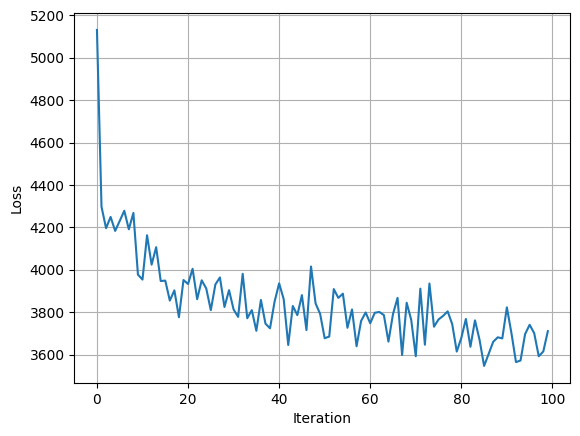

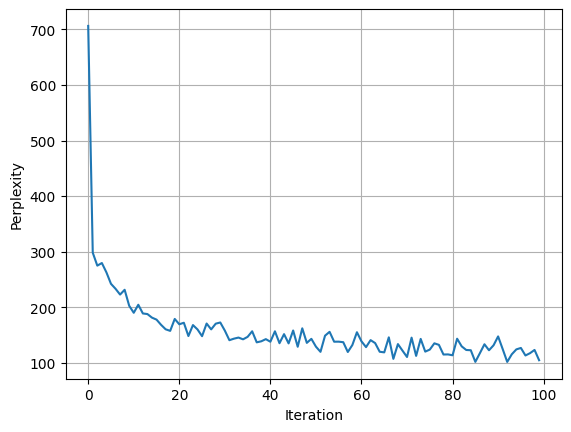

In [81]:
plt.plot(loss_avgs)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.grid(True)
plt.show()

plt.plot(perplexity_scores)
plt.ylabel("Perplexity")
plt.xlabel("Iteration")
plt.grid(True)
plt.show()

In [61]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=10):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [65]:
# Example call to evaluate function
searcher = GreedySearchDecoder(encoder, decoder)

# Input sentence
input_sentence = "how are you ?"

# Evaluate sentence
output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
output_sentence = ' '.join(output_words)

print('Input:', input_sentence)
print('Output:', output_sentence)

Input: how are you ?
Output: i yeah yeah i don't know i i i i


Input: how are you ?
Output: yeah i was the one i was in the bathroom

In [22]:
from collections import Counter
import itertools

def calculate_distinct_n_grams(sentences, n=1):
    """
    Calculate Distinct-N metric for a list of sentences.
    
    Parameters:
    - sentences: list of strings, where each string is a generated response or sentence.
    - n: integer, the n-gram length (1 for unigrams, 2 for bigrams, etc.)
    
    Returns:
    - distinct_n: The distinct-N metric, calculated as the number of unique n-grams
                  divided by the total number of n-grams.
    """
    # Tokenize the sentences into lists of words
    tokens_list = [sentence.split() for sentence in sentences]
    
    # Generate n-grams from tokens
    n_grams = list(itertools.chain(*[list(zip(*[tokens[i:] for i in range(n)])) for tokens in tokens_list]))
    
    # Count unique n-grams and total n-grams
    unique_n_grams = len(set(n_grams))
    total_n_grams = len(n_grams)
    
    # Calculate distinct-N metric
    distinct_n = unique_n_grams / total_n_grams if total_n_grams > 0 else 0
    return distinct_n


In [57]:
# Input utterances generated by chat-GPT
input_utts = [
    "Why do I always get stuck in the middle of everyone's problems ?",
    "Imagine if we could solve disputes with a dance-off instead of arguments .",
    "Do you think a penguin could be a good pet in the city ?",
    "I accidentally sent a love confession to the group chat , help !",
    "What's the weirdest thing you've ever done to impress a crush ?",
    "Have you ever walked into a room and forgotten why you're there ?",
    "Why is it that every time I try to cook , the fire alarm goes off ?",
    "I just tried talking to my crush , and I could only speak in movie quotes .",
    "If you had to choose , would you rather give up coffee or pizza ?",
    "Is it okay to wear socks with sandals if nobody's going to see ?",
    "Why do I feel like my laundry multiplies every time I blink ?",
    "Do you believe in love at first sight , or should I walk by again ?",
    "What's your take on eating pizza with a fork and knife ?",
    "Is talking to plants really supposed to help them grow ?",
    "I dreamed I was a muffin ; what do you think it means ?",
    "Why is it that I can never find my keys when I'm late ?",
    "Do you think ducks have best friends ?",
    "I just found out I've been using a word wrong my entire life .",
    "Would you rather fight one horse-sized duck or a hundred duck-sized horses ?",
    "What's the protocol for accidentally waving at someone who wasn't waving at you ?",
    "Do you ever practice conversations in your head before having them ?",
    "How many days in a row can you wear the same pair of jeans ?",
    "Why does my phone always die at the worst possible times ?",
    "Have you ever sent a text about someone to that person by accident ?",
    "What's the most embarrassing song you love ?",
    "Why do I feel like I need a vacation from my vacation ?",
    "Do you think it's possible to be too good at thumb wrestling ?",
    "What would you do if you found out you had a secret twin ?",
    "Why are my awkward moments always witnessed by the most people ?",
    "If you could have any superpower , but it had to be really mundane , what would it be ?",
    "What's the silliest reason you've ever had a falling out with someone ?",
    "Have you ever tried to bake something and it turned into a disaster ?",
    "Is double-dipping really that bad ?",
    "What's the strangest coincidence you've ever experienced ?",
    "Have you ever laughed so hard , no sound came out , and you just sat there clapping like a seal ?",
    "Why is it that when you're trying not to laugh , everything becomes ten times funnier ?",
    "Do you think if we didn't have thumbs , we'd still be the dominant species ?",
    "What's the best way to subtly escape a boring conversation ?",
    "Have you ever had a dream where you showed up to work in your pajamas ?",
    "Why do I always crave snacks right after I decide to start eating healthier ?",
    "Do you ever wonder what your pet names you in their head ?",
    "What's the worst haircut you've ever had ?",
    "Have you ever accidentally memorized a song you hate ?",
    "Why is deciding what to have for dinner the hardest decision of the day ?",
    "Is it really a road trip if you don't sing along to the radio at the top of your lungs ?",
    "Have you ever tried to make a recipe you saw in a cartoon ?",
    "What's the funniest thing you've ever seen a stranger do ?",
    "Do you think time travel will ever be possible , and if so , what time would you visit ?",
    "Why is it that every time I try to be cool , I end up doing something awkward ?",
    "If animals could talk , which species do you think would be the most annoying ?"
]


In [58]:
def unicodeToAscii(s):
    """
    Converts the Unicode string to plain ASCII.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    """
    Lowercase, trim, replace ellipses with a single full stop, 
    and remove non-letter characters except for basic punctuation.
    """
    # Convert to ASCII
    s = unicodeToAscii(s.lower().strip())
    # Replace ellipses with a single full stop
    s = re.sub(r"\.\s*\.\s*\.\s*", ". ", s)
    # Space out punctuation
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove non-letter characters except for basic punctuation
    s = re.sub(r"[^a-zA-Z.!?']+", r" ", s)
    # Replace multiple spaces with a single space
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [59]:
input_utts_normalized = [normalizeString(utt) for utt in input_utts]
input_utts_filtered = [input_utt for input_utt in input_utts_normalized if all(word in voc.word2index.keys() for word in input_utt.split())]

In [66]:
input_utts_filtered[:10]

["why do i always get stuck in the middle of everyone's problems ?",
 'do you think a penguin could be a good pet in the city ?',
 'i accidentally sent a love confession to the group chat help !',
 "what's the weirdest thing you've ever done to impress a crush ?",
 "have you ever walked into a room and forgotten why you're there ?",
 'why is it that every time i try to cook the fire alarm goes off ?',
 'if you had to choose would you rather give up coffee or pizza ?',
 'do you believe in love at first sight or should i walk by again ?',
 "what's your take on eating pizza with a fork and knife ?",
 'is talking to plants really supposed to help them grow ?']

In [67]:
len(input_utts), len(input_utts_filtered)

(50, 33)

In [73]:
searcher = GreedySearchDecoder(encoder, decoder)
attempts = 50
outputs = [[] for _ in range(len(input_utts_filtered))]

for idx, input_utt in enumerate(input_utts_filtered):
    print(f"Generating responses for input utterance {idx + 1} / {len(input_utts_filtered)}...")
    for _ in range(attempts):
        output_words = evaluate(encoder, decoder, searcher, voc, input_utt)
        output_utt = ' '.join(output_words)
        outputs[idx].append(output_utt)

Generating responses for input utterance 1 / 33...
Generating responses for input utterance 2 / 33...
Generating responses for input utterance 3 / 33...
Generating responses for input utterance 4 / 33...
Generating responses for input utterance 5 / 33...
Generating responses for input utterance 6 / 33...
Generating responses for input utterance 7 / 33...
Generating responses for input utterance 8 / 33...
Generating responses for input utterance 9 / 33...
Generating responses for input utterance 10 / 33...
Generating responses for input utterance 11 / 33...
Generating responses for input utterance 12 / 33...
Generating responses for input utterance 13 / 33...
Generating responses for input utterance 14 / 33...
Generating responses for input utterance 15 / 33...
Generating responses for input utterance 16 / 33...
Generating responses for input utterance 17 / 33...
Generating responses for input utterance 18 / 33...
Generating responses for input utterance 19 / 33...
Generating responses 

In [78]:
distinct_1 = [calculate_distinct_n_grams(outputs[i], n=1) for i in range(len(input_utts_filtered))]
distinct_2 = [calculate_distinct_n_grams(outputs[i], n=2) for i in range(len(input_utts_filtered))]

print(f"Distinct-1: {np.mean(distinct_1):.4f}")
print(f"Distinct-2: {np.mean(distinct_2):.4f}")

Distinct-1: 0.0121
Distinct-2: 0.0208


In [88]:
import torch
import torch.nn.functional as F

class BeamSearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, voc, beam_width=5):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.voc = voc
        self.beam_width = beam_width

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length, None)

        # Tensor to store decoder outputs
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)

        # Start with the start of the sentence token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        decoder_hidden = encoder_hidden[:decoder.n_layers]

        # Now, instead of just looking for the most likely next step, 
        # keep track of the top k choices at each step; initialize beams
        beams = [(decoder_input, decoder_hidden, 0, [])] # Each beam is a tuple (decoder_input, decoder_hidden, score, token_list)

        for _ in range(max_length):
            candidates = []
            for beam in beams:
                decoder_input, decoder_hidden, score, token_list = beam
                with torch.no_grad():
                    decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                log_probs = F.log_softmax(decoder_output, dim=1)
                top_log_probs, top_idxs = log_probs.topk(self.beam_width)

                for i in range(self.beam_width):
                    next_token_log_prob = top_log_probs[0][i].item()
                    next_token_idx = top_idxs[0][i].item()

                    candidates.append((torch.ones(1, 1, device=device, dtype=torch.long) * next_token_idx, decoder_hidden, score + next_token_log_prob, token_list + [next_token_idx]))

            # Sort candidates by score and select top k
            candidates = sorted(candidates, key=lambda x: x[2], reverse=True)[:self.beam_width]
            beams = candidates

        # Choose the beam with the highest score
        _, _, final_score, final_tokens = max(beams, key=lambda x: x[2])

        all_tokens = torch.tensor(final_tokens, device=device)
        all_scores = torch.tensor(final_score, device=device)
        return all_tokens, all_scores

def evaluate_beam_search(encoder, decoder, voc, sentence, max_length=10, beam_width=5):
    ### Format input sentence as a batch
    indexes_batch = [indexesFromSentence(voc, sentence)]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1).to(device)
    lengths = lengths.to("cpu")
    
    # Decode sentence with beam search
    searcher = BeamSearchDecoder(encoder, decoder, voc, beam_width=beam_width)
    tokens, scores = searcher(input_batch, lengths, max_length)
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


In [93]:
# Input sentence
input_sentence = "how are you ?"

# Evaluate sentence
output_words = evaluate_beam_search(encoder, decoder, voc, input_sentence)
output_sentence = ' '.join(output_words)

print('Input:', input_sentence)
print('Output:', output_sentence)

Input: how are you ?
Output: yeah yeah yeah i did it . EOS . EOS


In [94]:
attempts = 50
outputs = [[] for _ in range(len(input_utts_filtered))]

for idx, input_utt in enumerate(input_utts_filtered):
    print(f"Generating responses for input utterance {idx + 1} / {len(input_utts_filtered)}...")
    for _ in range(attempts):
        output_words = evaluate_beam_search(encoder, decoder, voc, input_utt)
        output_utt = ' '.join(output_words)
        outputs[idx].append(output_utt)

Generating responses for input utterance 1 / 33...
Generating responses for input utterance 2 / 33...
Generating responses for input utterance 3 / 33...
Generating responses for input utterance 4 / 33...
Generating responses for input utterance 5 / 33...
Generating responses for input utterance 6 / 33...
Generating responses for input utterance 7 / 33...
Generating responses for input utterance 8 / 33...
Generating responses for input utterance 9 / 33...
Generating responses for input utterance 10 / 33...
Generating responses for input utterance 11 / 33...
Generating responses for input utterance 12 / 33...
Generating responses for input utterance 13 / 33...
Generating responses for input utterance 14 / 33...
Generating responses for input utterance 15 / 33...
Generating responses for input utterance 16 / 33...
Generating responses for input utterance 17 / 33...
Generating responses for input utterance 18 / 33...
Generating responses for input utterance 19 / 33...
Generating responses 

In [ ]:
distinct_1 = [calculate_distinct_n_grams(outputs[i], n=1) for i in range(len(input_utts_filtered))]
distinct_2 = [calculate_distinct_n_grams(outputs[i], n=2) for i in range(len(input_utts_filtered))]

print(f"Distinct-1: {np.mean(distinct_1):.4f}")
print(f"Distinct-2: {np.mean(distinct_2):.4f}")